In [ ]:
using LinearAlgebra
using Plots, Plots.PlotMeasures
using Colors
using LaTeXStrings
using MAT
using FFTW

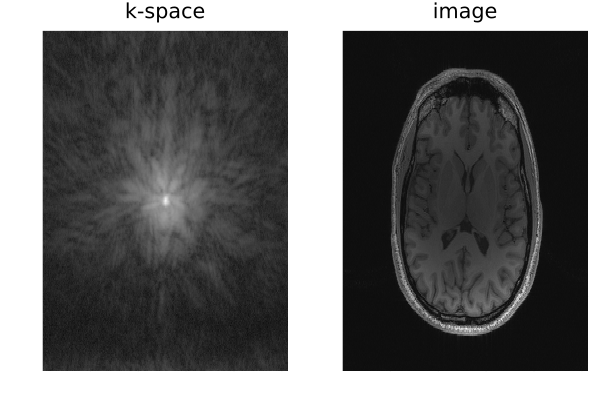

In [20]:
# load in the 2D data
kdata = 1e8 * matread("./2D_T1_human_data.mat")["kData"];
idata = fftshift(ifft(ifftshift(kdata,1:2),1:2),1:2);

# take rsos for visualization
kdata_rsos = sqrt.(sum(abs2.(kdata); dims=3))[:,:,1];
idata_rsos = sqrt.(sum(abs2.(idata); dims=3))[:,:,1];

p1 = heatmap(log.(kdata_rsos), color=:grays, colorbar=false, axis=false, yflip=true, title="k-space")
p2 = heatmap(idata_rsos, color=:grays, colorbar=false, axis=false, yflip=true, title="image")

plot(p1,p2)

In [133]:
# function to define trapezoid given area, max height, and max first derivative
function trap_A(A, hmax, smax)

    # get initial height
    h = min(hmax, sqrt(A / smax))

    # get number of discrete ramp points
    nramp = ceil(Int, h / smax)

    # get number of discrete plateau points
    Aplat = A - h * nramp
    nplat = ceil(Int, max(0, Aplat / h))

    # adjust height
    h = A / (nramp + nplat)

    # form trapezoid
    trap = h / nramp * collect(1:nramp) # ramp up
    append!(trap, h * ones(nplat)) # plateau
    append!(trap, h / nramp * collect(nramp-1:-1:0)) # ramp down

    return (trap,h,nramp,nplat)
end

function trap_hl(h, l, smax)

    # get number of discrete ramp points
    nramp = ceil(Int, h / smax)

    # get number of discrete plateau points
    nplat = ceil(Int, l)

    # form trapezoid
    trap = h / nramp * collect(1:nramp) # ramp up
    append!(trap, h * ones(nplat)) # plateau
    append!(trap, h / nramp * collect(nramp-1:-1:0)) # ramp down

    return (trap,h,nramp,nplat)
end

function epi(nx,ny;ry=1,sr=0.05)

    # create frequency encode gradient
    (trap_fe,a_fe,nramp_fe,nplat_fe) = trap_hl(1,nx,sr)
    gx_fe = trap_fe
    gy_fe = zeros(length(trap_fe))
    acq_fe = vcat(zeros(length(nramp_fe)), ones(length(nplat_fe)), zeros(nramp_fe))

    # create phase encode gradient
    (trap_pe,a_pe,nramp_pe,nplat_pe) = trap_A(1/ry,1,sr)
    gx_pe = zeros(length(trap_pe))
    gy_pe = trap_pe
    acq_pe = zeros(length(trap_pe))

    # create prephaser gradient
    A_ppx = a_fe * (nplat_fe + nramp_fe) / 2
    A_ppy = (ny/ry)/2
    (trap_ppx,_,_,_) = trap_A(A_ppx,1,sr)
    (trap_ppy,_,_,_) = trap_A(A_ppy,1,sr)
    if length(trap_ppx) > length(trap_ppy)
        gx_pp = -trap_ppx
        gy_pp = vcat(-trap_ppy, zeros(length(trap_ppx) - length(trap_ppy)))
    else
        gx_pp = vcat(-trap_ppx, zeros(length(trap_ppy) - length(trap_ppx)))
        gy_pp = -trap_ppy
    end
    acq_pp = zeros(length(gx_pp))

    # build EPI trajectory
    gx_epi = gx_pp
    gy_epi = gy_pp
    acq_epi = acq_pp
    for i in 1:ny
        # frequency encode
        append!(gx_epi, (-1)^(i-1)*gx_fe)
        append!(gy_epi, gy_fe)
        append!(acq_epi, acq_fe)

        if i < ny
            # phase encode
            append!(gx_epi, gx_pe)
            append!(gy_epi, gy_pe)
            append!(acq_epi, acq_pe)
        end
    end

    return gx_epi, gy_epi, acq_epi
end

epi (generic function with 2 methods)

┌ Info: Saved animation to /var/folders/0g/9yswjs9x53vgk112mrdn05mm0000gn/T/jl_oj4h2topud.gif
└ @ Plots /Users/djfrey/.julia/packages/Plots/xKhUG/src/animation.jl:156


Plots.AnimatedGif("/var/folders/0g/9yswjs9x53vgk112mrdn05mm0000gn/T/jl_oj4h2topud.gif")
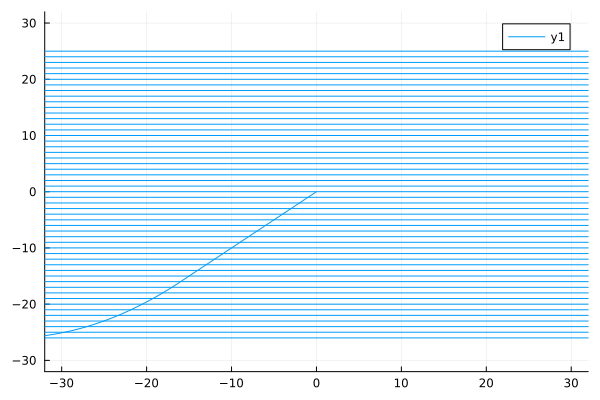

In [170]:
nx = 64
ny = 32

npts = 20
@gif for i in 1:npts

    resfac = 1.5 + 0.5*sin(2 * pi * i / npts)

     # phase oversample
    (gx,gy,acq) = epi(nx,floor(ny*resfac);ry=1)
    kx = cumsum(gx)
    ky = cumsum(gy)

    plot(kx,ky,xlim=(-32,32),ylim=(-32,32))

end fps = 10

In [152]:
pos = 1 + sin(2 * pi * 3 / 100)

1.1873813145857246